In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
class df_preparation:
    def __init__(self, training_df, df):
        self.training_df = training_df
        self.df = df

    def change_numeric(self):
        def change_blood_type():
            self.df['A'] = self.df["blood_type"].isin(["A+", "A-"]).apply(lambda x: int(x))
            self.df['A'] = self.df["blood_type"].isin(["A+", "A-"]).apply(lambda x: int(x))
            self.df['B'] = self.df["blood_type"].isin(["B+", "B-", "AB+", "AB-"]).apply(lambda x: int(x))
            self.df['O'] = self.df["blood_type"].isin(["O+", "O-"]).apply(lambda x: int(x))
            self.df.drop('blood_type', axis=1, inplace=True)

        def change_current_location():
            self.df["current_location_x"] = self.df["current_location"].apply(lambda x: (x.split(","))[0][2:-1]).astype(float)
            self.df["current_location_y"] = self.df["current_location"].apply(lambda x: (x.split(","))[1][2:-2]).astype(float)
            self.training_df["current_location_x"] = self.training_df["current_location"].apply(
                lambda x: (x.split(","))[0][2:-1]).astype(float)
            self.training_df["current_location_y"] = self.training_df["current_location"].apply(
                lambda x: (x.split(","))[1][2:-2]).astype(float)
            self.df.drop('current_location', axis=1, inplace=True)

        change_current_location()
        change_blood_type()

    def change_categorical_features(self):
        def change_symptoms():
            self.df["low_appetite"] = self.df["symptoms"].str.contains("low_appetite").fillna(value=False).apply(
                lambda x: int(x))
            self.df["cough"] = self.df["symptoms"].str.contains("cough").fillna(value=False).apply(lambda x: int(x))
            self.df["shortness_of_breath"] = self.df["symptoms"].str.contains("shortness_of_breath").fillna(
                value=False).apply(lambda x: int(x))
            self.df["fever"] = self.df["symptoms"].str.contains("fever").fillna(value=False).apply(lambda x: int(x))
            self.df["sore_throat"] = self.df["symptoms"].str.contains("sore_throat").fillna(value=False).apply(
                lambda x: int(x))
            self.df.drop('symptoms', axis=1, inplace=True)

        change_symptoms()

    def drop_features(self):
        self.df.drop(['pcr_date', 'sex', 'patient_id'], axis=1, inplace=True)

    def normalization(self):
        def stdNormal(feature):
            df = self.df[[feature]]
            scaler = StandardScaler()
            scaler.fit(self.training_df[[feature]])  # scaling on training!
            normalaized_feature = scaler.transform(df)
            self.df[feature] = normalaized_feature

        def minMaxNormal(feature):
            df = self.df[[feature]]
            scaler = MinMaxScaler((-1, 1))
            scaler.fit(self.training_df[[feature]])  # scaling on training!
            normalaized_feature = scaler.transform(df)
            self.df[feature] = normalaized_feature

        min_max_features = ['age', 'PCR_03', 'PCR_04', 'PCR_05', 'happiness_score', 'conversations_per_day',
                            'sport_activity', 'PCR_01', 'PCR_02', 'PCR_07', 'PCR_09', 'current_location_y',
                            'num_of_siblings']
        std_features = ['weight', 'sugar_levels', 'household_income', 'PCR_06', 'PCR_08', 'PCR_10',
                        'current_location_x']

        [stdNormal(feature) for feature in std_features]
        [minMaxNormal(feature) for feature in min_max_features]


def prepare_data(training_df, new_data):
    training_df=training_df.copy()
    df=new_data.copy()
    new_data_return = df_preparation(training_df=training_df, df=df)
    new_data_return.change_categorical_features()
    new_data_return.change_numeric()
    new_data_return.drop_features()
    new_data_return.normalization()

    return new_data_return.df

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
url = "/content/data_HW3.csv"

df = pd.read_csv(url, header=0)
X_train_init, X_test_init = train_test_split( df, test_size=0.2, train_size=0.8, random_state=10)
X_train_processed = prepare_data(X_train_init, X_train_init)
X_test_processed = prepare_data(X_train_init, X_test_init)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import math

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# New Section

In [ ]:
from sklearn.base import BaseEstimator, RegressorMixin
import numpy as np


class LinearRegressor(BaseEstimator, RegressorMixin):
    """
    Custom linear regression model
    """
    def __init__(self, lr: float = 1e-5, delta: float = 1.0):
        """
        Initialize an instance of this class.
        ** Do not edit this method **

        :param lr: the SGD learning rate (step size)
        """
        self.lr = lr
        self.batch_size = 32
        self.w = None
        self.b = 0.0
        self.delta = delta

    # Initialize a random weight vector
    def init_solution(self, n_features: int):
        """
        Randomize an initial solution (weight vector)
        ** Do not edit this method **

        :param n_features:
        """
        self.w = np.zeros(n_features)
        self.b = 0.0

    @staticmethod
    def loss(w, b: float, X, y, delta: float):
        """
        Compute the MSE objective loss.

        :param w: weight vector for linear regression; array of shape (n_features,)
        :param b: bias scalar for linear regression
        :param X: samples for loss computation; array of shape (n_samples, n_features)
        :param y: targets for loss computation; array of shape (n_samples,)
        :return: the linear regression objective loss (float scalar)
        """

        residuals = np.dot(X, w) + b - y

        huber_residuals = np.abs(residuals)

        squared_loss = 0.5*huber_residuals**2
        linear_loss = delta*(huber_residuals-0.5*delta)

        loss = np.where(huber_residuals<=delta, squared_loss, linear_loss)
        return np.mean(loss)

    @staticmethod
    def gradient(w, b: float, X, y, delta: float):
        """
        Compute the (analytical) linear regression objective gradient.

        :param w: weight vector for linear regression; array of shape (n_features,)
        :param b: bias scalar for linear regression
        :param X: samples for loss computation; array of shape (n_samples, n_features)
        :param y: targets for loss computation; array of shape (n_samples,)
        :return: a tuple with (the gradient of the weights, the gradient of the bias)
        """
        # TODO: calculate the analytical gradient w.r.t w and b

        m = X.shape[0]
        residuals = np.dot(X, w) + b - y

        huber_residuals = np.abs(residuals)

        derivative_quadratic = np.where(huber_residuals <= huber_delta, residuals, np.sign(residuals) * huber_delta)

        g_w = np.dot(X.T, derivative_quadratic) / len(y)
        g_b = np.mean(derivative_quadratic)

        return g_w, g_b

    def fit_with_logs(self, X, y, max_iter: int = 1000, keep_losses: bool = True,
                      X_val  =None, y_val = None):
        """
        Fit the model according to the given training data.

        :param X: training samples; array of shape (n_samples, n_features)
        :param y: training targets; array of shape (n_samples,)
        :param max_iter: number of SGD iterations
        :param keep_losses: should compute the train & val losses during training?
        :param X_val: validation samples to compute the loss for (for logs only)
        :param y_val: validation labels to compute the loss for (for logs only)
        :return: training and validation losses during training
        """
        # Initialize learned parameters
        self.init_solution(X.shape[1])

        train_losses = []
        val_losses = []

        if keep_losses:
            train_losses.append(self.loss(self.w, self.b, X, y, self.delta))
            val_losses.append(self.loss(self.w, self.b, X_val, y_val, self.delta))

        # Iterate over batches (SGD)
        for itr in range(0, max_iter):
            start_idx = (itr * self.batch_size) % X.shape[0]
            end_idx = min(X.shape[0], start_idx + self.batch_size)
            batch_X = X[start_idx: end_idx]
            batch_y = y[start_idx: end_idx]

            # TODO: Compute the gradient for the current *batch*
            g_w, g_b = self.gradient(self.w, self.b, batch_X, batch_y, self.delta)

            # Perform a gradient step
            # TODO: update the learned parameters correctly
            self.w = self.w - self.lr * g_w
            self.b = self.b - self.lr * g_b

            if keep_losses:
                train_losses.append(self.loss(self.w, self.b,  X, y, self.delta))
                val_losses.append(self.loss(self.w, self.b,  X_val, y_val, self.delta))

        return train_losses, val_losses

    def fit(self, X, y, max_iter: int = 1000):
        """
        Fit the model according to the given training data.
        ** Do not edit this method **

        :param X: training samples; array of shape (n_samples, n_features)
        :param y: training targets; array of shape (n_samples,)
        :param max_iter: number of SGD iterations
        """
        self.fit_with_logs(X, y, max_iter=max_iter, keep_losses=False)

        return self

    def predict(self, X):
        """
        Regress labels on samples in X.

        :param X: samples for prediction; array of shape (n_samples, n_features)
        :return: Predicted continuous labels for samples in X; array of shape (n_samples,)
        """

        # TODO: Compute
        y_pred = np.dot(X, self.w) + self.b

        return y_pred

In [ ]:
def plot3d(df, colX:str, colY:str, colZ:str, title:str, predictions=None):
  fig = plt.figure(figsize=(20, 7))
  axes = [fig.add_subplot(1, 3, i+1, projection='3d') for i in range(3)]

  palette = sns.color_palette("hls", 2)

  for i,ax in enumerate(axes):
    if predictions is not None:
      ax.scatter3D(df[colX], df[colY], predictions, color=palette[1], s=3)
      ax.scatter3D(df[colX], df[colY], df[colZ], color=palette[0], s=1,
                   alpha=0.35, depthshade=False)
    else:
      ax.scatter3D(df[colX], df[colY], df[colZ], color=palette[0], s=1)

    ax.set_xlabel(colX)
    ax.set_ylabel(colY)
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])

    ax.view_init(elev=5., azim=45*i)

  axes[0].set_zlabel("\n" + colZ, linespacing=2.2)

  plt.suptitle(title, fontsize=32)
  plt.tight_layout()
  plt.show()

In [ ]:
def numerical_subgradient(w, b, X, y, huber_delta: float, delta=1e-4):
    w_ = w.copy()
    g_w = np.zeros_like(w_)
    orig_objective = LinearRegressor.loss(w_, b, X, y, huber_delta)
    for i in range(g_w.shape[0]):
        w_[i] += delta
        perturbed_objective = LinearRegressor.loss(w_, b, X, y, huber_delta)
        w_[i] -= delta
        g_w[i] = (perturbed_objective - orig_objective) / delta

    g_b = (LinearRegressor.loss(w_, b + delta, X, y, huber_delta) - orig_objective) / delta
    return g_w, g_b


def compare_gradients(X, y, huber_delta: float, deltas, C=1, REPEATS=10, figsize=(10, 6)):
    residual_means_w = []
    residual_means_b = []

    for delta in deltas:
        residuals_w = []
        residuals_b = []

        for _ in range(REPEATS):
            # Randomize vectors in which the gradient is computed
            w = np.random.randn(X.shape[1])
            b = np.random.randn(1)

            # Compute the two types of gradients
            analytic_grad_w, analytic_grad_b = LinearRegressor.gradient(w, b, X, y, huber_delta)

            numeric_grad_w, numeric_grad_b = numerical_subgradient(w, b, X, y, huber_delta, delta=delta)

            residual_w = np.linalg.norm(numeric_grad_w - analytic_grad_w)
            residuals_w.append(residual_w)

            residual_b = np.linalg.norm(numeric_grad_b - analytic_grad_b)
            residuals_b.append(residual_b)

        residual_means_w.append(np.mean(residuals_w))
        residual_means_b.append(np.mean(residuals_b))

    fig, axs = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(16, 8))
    plt.suptitle('Residuals of analytical and numerical gradients',
                 fontsize=22, fontweight="bold")
    axs[0].set_title(r'Residuals of $\nabla_{w}L\left(w,b\right)$')
    axs[1].set_title(r'Residuals of $\frac{\partial}{\partial{b}}L\left(w,b\right)$')
    axs[0].plot(deltas, residual_means_w, linewidth=3)
    axs[1].plot(deltas, residual_means_b, linewidth=3)
    axs[0].set_yscale('log')
    axs[0].set_xscale('log')
    axs[1].set_yscale('log')
    axs[1].set_xscale('log')
    axs[0].set_xlabel('$\delta_w$', fontsize=18)
    axs[1].set_xlabel('$\delta_b$', fontsize=18)
    axs[0].set_ylabel(r'$\left\Vert \nabla_{w}L\left(w,b\right) - u_{\delta_w} \left(w,b\right)\right\Vert$',
                      fontsize=18)
    axs[1].set_ylabel(
        r'$\left\Vert \frac{\partial}{\partial{b}}L\left(w,b\right) - u_{\delta_b} \left(w,b\right)\right\Vert$',
        fontsize=18)

    axs[0].grid(alpha=0.5)
    axs[1].grid(alpha=0.5)
    plt.show()


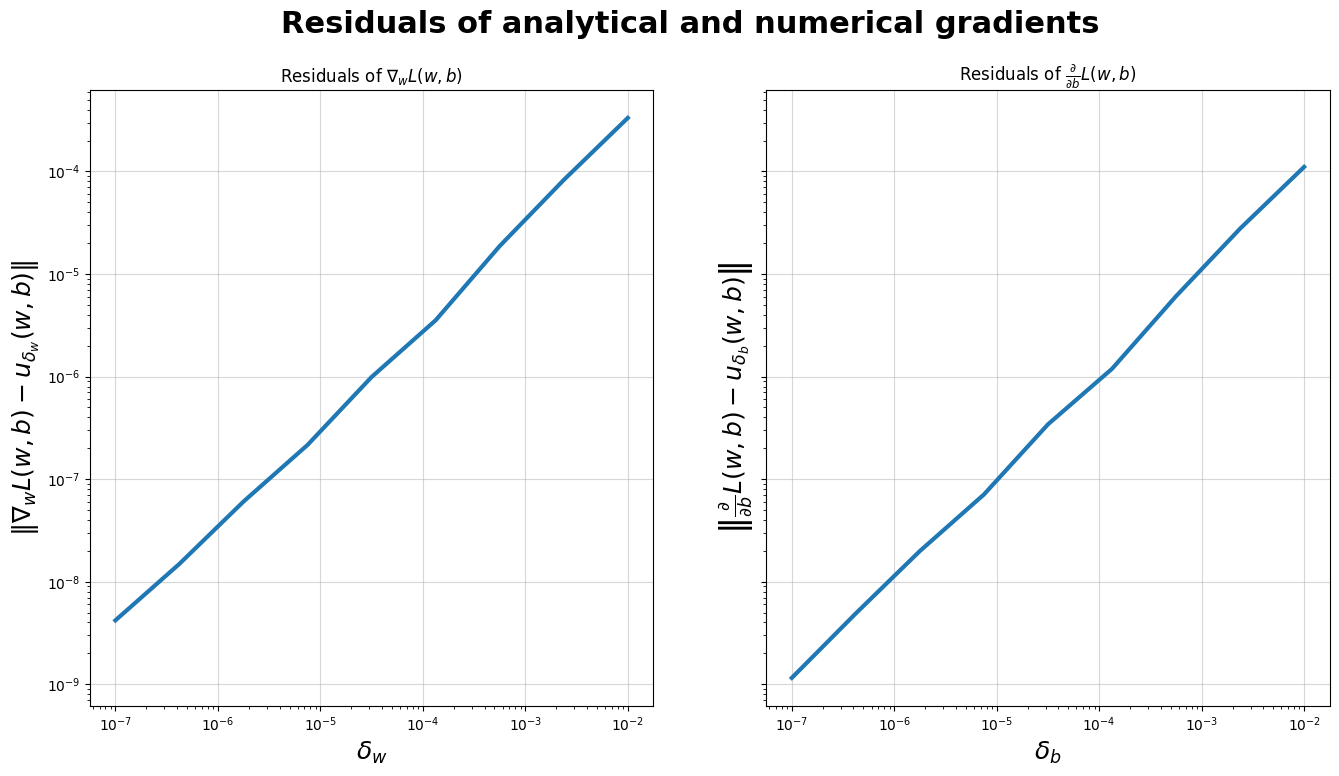

In [ ]:
#Q4.
X_train, X_validation = train_test_split(X_train_processed, test_size=0.2, train_size=0.8, random_state=11)
y_train = X_train['contamination_level']
y_validation = X_validation['contamination_level']

huber_delta = 0.1

del X_train['contamination_level']
del X_validation['contamination_level']

compare_gradients(X_train, y_train, huber_delta, deltas=np.logspace(-7, -2, 9))


In [ ]:
#Q5
import matplotlib.pyplot as plt
import numpy as np


def test_lr(X_train, y_train, X_val, y_val, huber_delta: float, title: str, max_iter: int = 1500):
  lr_list = np.logspace(-9, -1, 9)

  fig, axs = plt.subplots(3, 3, sharey=True, figsize=(20, 12))
  plt.suptitle(title, fontsize=32)
  plt.tight_layout()
  fig.subplots_adjust(hspace=0.5, top=0.9)

  axs = np.ravel(axs)
  for i, lr in enumerate(lr_list):
    cur_linear_reggressor = LinearRegressor(lr, huber_delta)
    train_losses, val_losses = cur_linear_reggressor.fit_with_logs(X_train, y_train, keep_losses=True, X_val=X_val, y_val=y_val, max_iter=max_iter)
    print('lr size = '+str(lr)+', Best train loss = '+str(min(train_losses))+', Best validation loss = ' + str(min(val_losses)))

    iterations = np.arange(max_iter + 1)
    axs[i].semilogy(iterations, train_losses, label="Train")
    axs[i].semilogy(iterations, val_losses, label="Validation")
    axs[i].grid(alpha=0.5)
    axs[i].legend()
    axs[i].set_title('lr = '+str(lr))
    axs[i].set_xlabel('iteration')
    axs[i].set_ylabel('MSE')

In [ ]:
regressor = LinearRegressor()
regressor.fit(X_train_processed, X_train_processed['contamination_level'])

y_pred = regressor.predict(X_train_processed)
residuals = X_train_processed['contamination_level'] - y_pred

huber_delta = np.quantile(residuals, 0.9)
huber_delta


4.896002458929109

lr size = 1e-09, Best train loss = 2.9986839531428466, Best validation loss = 3.369955138871026
lr size = 1e-08, Best train loss = 2.9986355346952474, Best validation loss = 3.36990298849489
lr size = 1e-07, Best train loss = 2.9981515270553625, Best validation loss = 3.3693816678156967
lr size = 1e-06, Best train loss = 2.993329107353044, Best validation loss = 3.364186733168955
lr size = 1e-05, Best train loss = 2.946827582665426, Best validation loss = 3.314020228488047
lr size = 0.0001, Best train loss = 2.6174446287401505, Best validation loss = 2.9535827560956873
lr size = 0.001, Best train loss = 2.144119924287877, Best validation loss = 2.416932982305687
lr size = 0.01, Best train loss = 1.7994796797682284, Best validation loss = 2.0676673014810296
lr size = 0.1, Best train loss = 1.7835415547732003, Best validation loss = 2.061164392832915


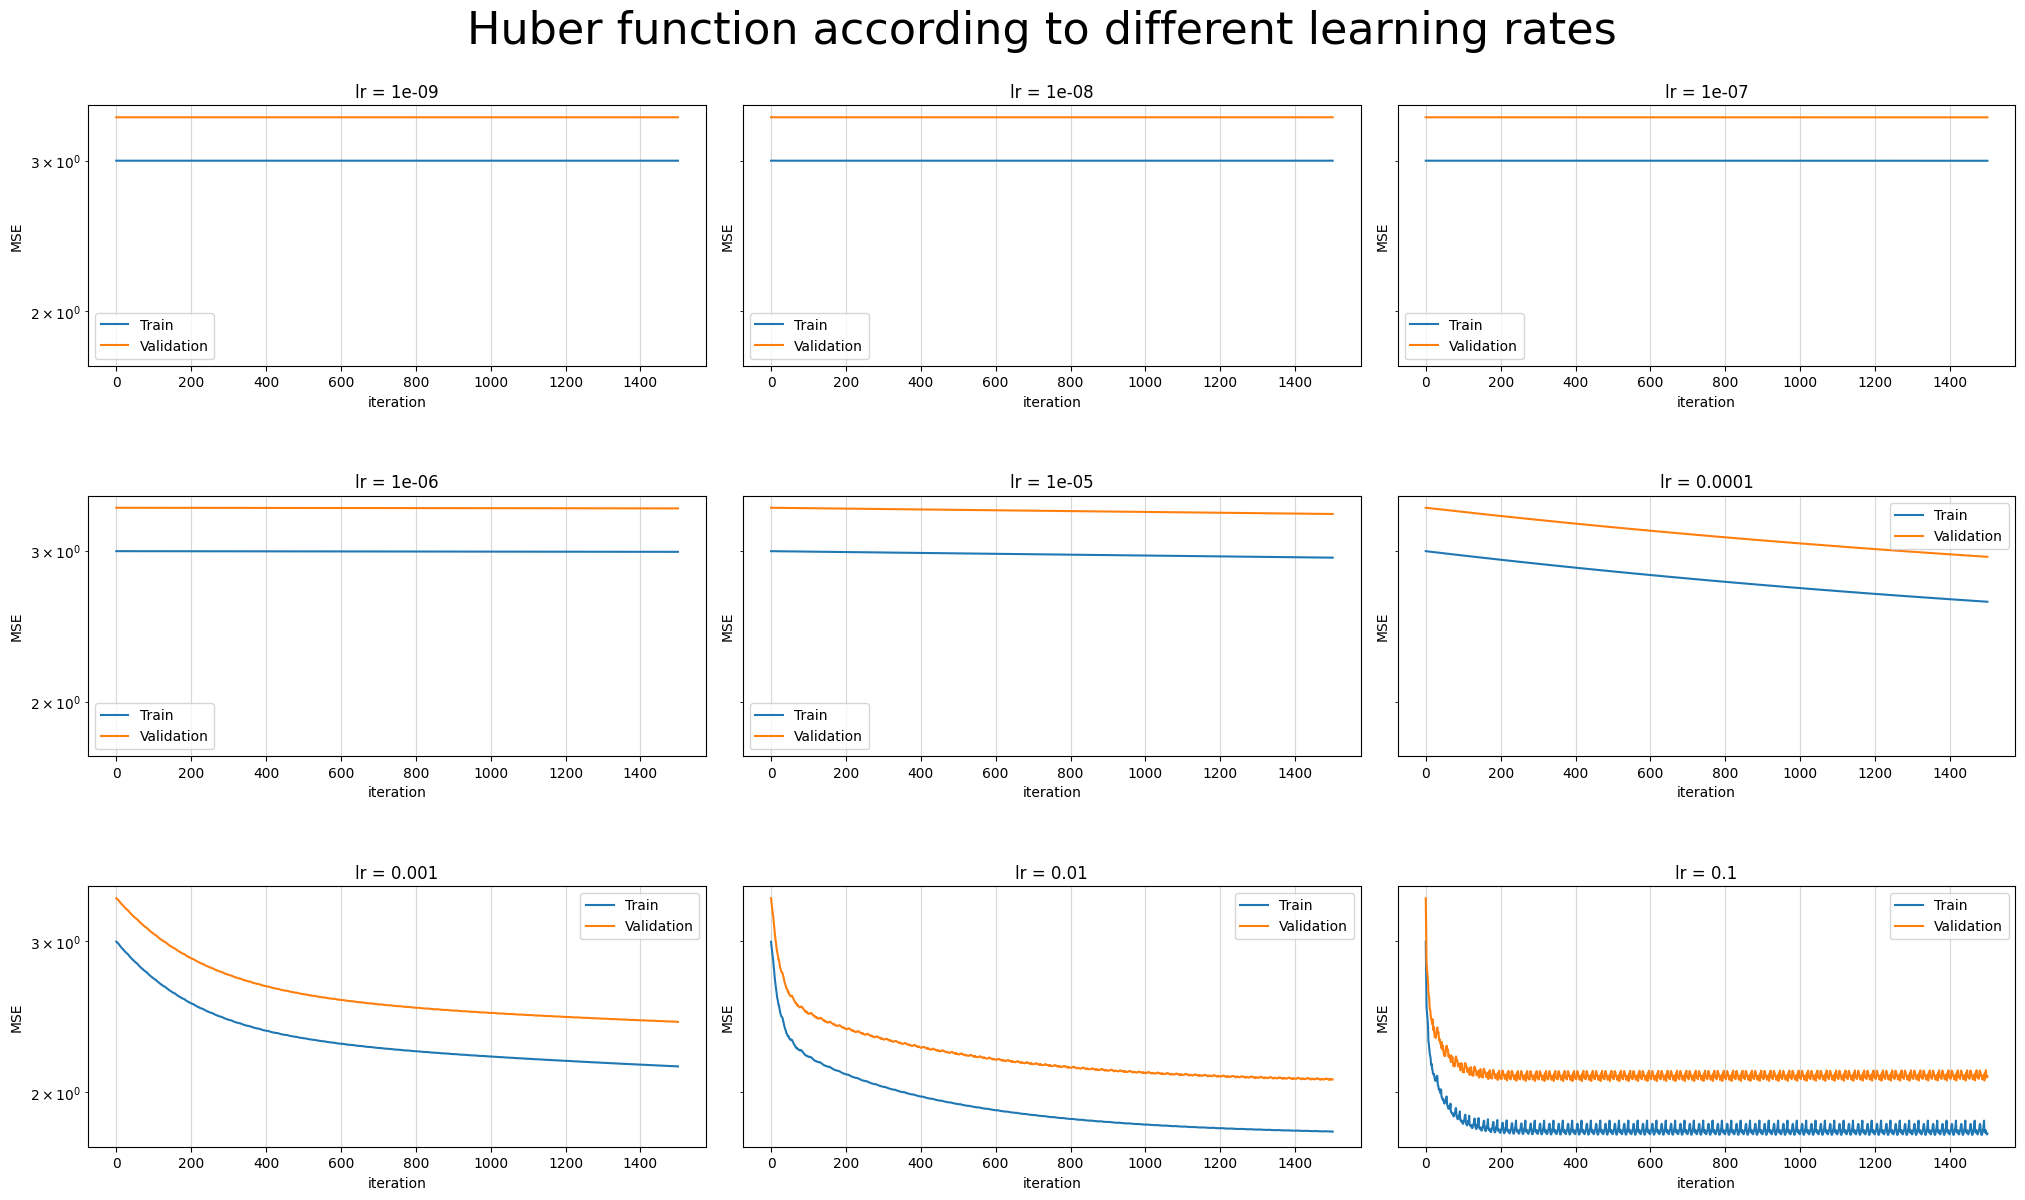

In [ ]:
#Q5
test_lr(X_train, y_train, X_validation, y_validation, huber_delta, "Huber function according to different learning rates")

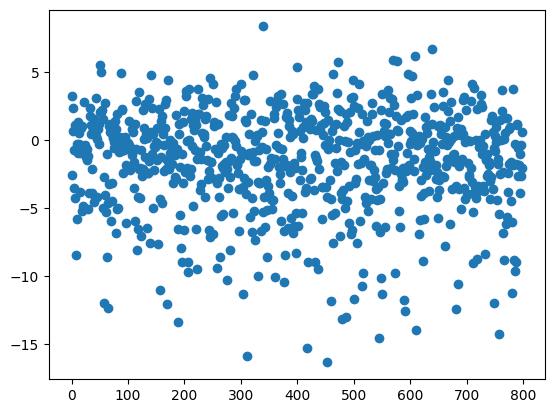

In [ ]:

w = np.random.randn(X_train.shape[1])
b = np.random.randn(1)
plt.scatter(np.arange(X_train.shape[0]), np.dot(X_train, w) + b * np.ones(X_train.shape[0]) - y_train)

In [ ]:
lr = 0.01

In [ ]:
# @title Section 2
#Q7
import numpy as np
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.metrics import make_scorer , mean_squared_error

X_train_from_section2 = X_train_processed.copy()
y_train_from_section2 = X_train_from_section2['contamination_level']

del X_train_from_section2['contamination_level']

def huber_loss(y_true, y_pred, delta=huber_delta):
    diff = np.abs(y_true - y_pred)
    loss = np.where(diff <= delta, 0.5 * diff**2, delta * (diff - 0.5 * delta))
    return np.mean(loss)

dummy_regr = DummyRegressor(strategy="mean")

huber_loss_scorer = make_scorer(huber_loss , greater_is_better = False)
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

cv_results = cross_validate(dummy_regr, X_train, y_train, cv=5 ,scoring={'huber_loss':huber_loss_scorer ,'mse_scorer':mse_scorer },return_train_score=True)
dummy_train_loss = -1 * np.mean(cv_results['train_huber_loss'])
dummy_val_hub_loss = -1 * np.mean(cv_results['test_huber_loss'])
dummy_mse_train_loss = -1*np.mean(cv_results['train_mse_scorer'])
dummy_mse_val_loss = -1*np.mean(cv_results['test_mse_scorer'])

#Task
dummy_regr.fit(X_train, y_train)

print("Train mse loss is : ", dummy_mse_train_loss)
print("MSE val loss is : ", dummy_mse_val_loss)


Train mse loss is :  5.168851338092024
MSE val loss is :  5.183823516550158


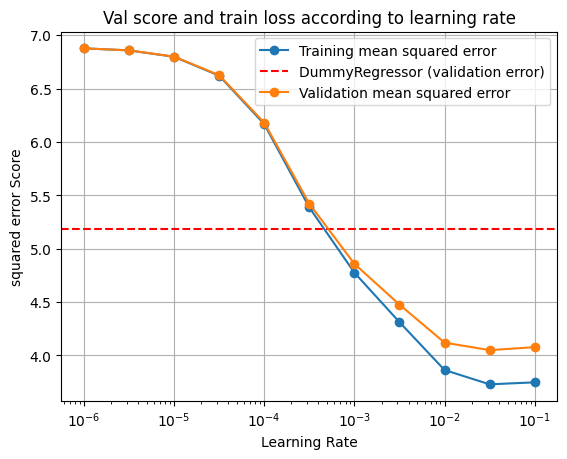

In [ ]:
#Q8
lr_list = np.logspace(-6,-1,11)
scores = []
#delta = 1 #to change

train_scores_mean = []
test_scores_mean = []

for lr in lr_list :
    reg = LinearRegressor(lr, delta = huber_delta)
    cv_results = cross_validate(reg, X_train_from_section2, y_train_from_section2, cv=5, return_train_score=True, scoring='neg_mean_squared_error')

    train_score_mean = np.mean(cv_results['train_score'])
    test_score_mean = np.mean(cv_results['test_score'])

    scores.append([-1 * cv_results['test_score'].mean(), -1 * cv_results['train_score'].mean()])

    train_scores_mean.append(np.absolute(train_score_mean))
    test_scores_mean.append(np.absolute(test_score_mean))


optimal_validation_index  = np.argmin(test_scores_mean)
optimal_lr_value = lr_list[optimal_validation_index]
optimal_val_error = test_scores_mean[optimal_validation_index]

plt.semilogx(lr_list, train_scores_mean, label='Training mean squared error', marker='o')


dummy_regressor = DummyRegressor(strategy="mean")
dummy_val_error = -cross_val_score(dummy_regressor ,X_train, y_train,cv=5, scoring= 'neg_mean_squared_error').mean()
plt.axhline( y = dummy_val_error , color = 'r',linestyle = '--',label = 'DummyRegressor (validation error)')
plt.semilogx(lr_list, test_scores_mean, label='Validation mean squared error', marker='o')

plt.ylabel('squared error Score')
plt.xlabel('Learning Rate')
plt.title('Val score and train loss according to learning rate')
plt.legend()
plt.grid(True)
plt.show()



In [ ]:
optimal_validation_index  = np.argmin(test_scores_mean)

optimal_lr_value = lr_list[optimal_validation_index]
optimal_val_error = test_scores_mean[optimal_validation_index]
optimal_train_error = train_scores_mean[optimal_validation_index]

print("Optimal LR value: ",optimal_lr_value )
print("Optimal validation value: ",optimal_val_error )
print("Optimal train value: ",optimal_train_error)


Optimal LR value:  0.03162277660168379
Optimal validation value:  4.049811994116021
Optimal train value:  3.729319902447764


In [ ]:
#Section 3: Ridge Regression

#Q10
from sklearn.linear_model import HuberRegressor, Ridge

alpha_list = np.logspace(-3, 10,25)
val_sc_mean = []
train_sc_mean = []
dummy_error = []


scores = []
for alpha in alpha_list:
    huber_reg = HuberRegressor(alpha = alpha ,epsilon = huber_delta, fit_intercept=True)
    cv = cross_validate(huber_reg, X_train, y_train, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
    train_sc_mean.append(np.absolute(np.mean(cv['train_score'])))
    val_sc_mean.append(np.absolute(np.mean(cv['test_score'])))
    dummy_error.append(dummy_val_error)




Train score mean:  3.647272273618203
Min Validation error:  3.993596531951426
Optimal alpha index:  7


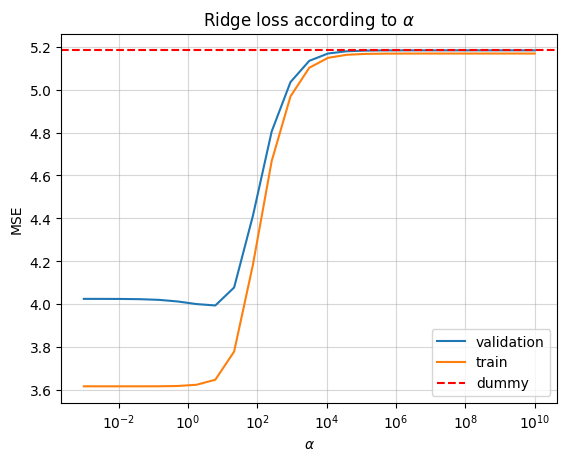

In [ ]:
optimal_validation_index  = np.argmin(val_sc_mean)
print("Train score mean: ", train_sc_mean[optimal_validation_index])
print("Min Validation error: ", val_sc_mean[optimal_validation_index])
print("Optimal alpha index: ", optimal_validation_index)

plt.semilogx(alpha_list, val_sc_mean, label="Validation Score")
plt.semilogx(alpha_list, train_sc_mean, label="Train Score")
plt.axhline( y = dummy_val_error , color = 'r',linestyle = '--',label = 'DummyRegressor (validation error)')
plt.grid(alpha=0.5, visible=True)
plt.ylabel("MSE")
plt.xlabel("$\\alpha$")
plt.title("Ridge loss according to $\\alpha$")
plt.legend(["validation", "train", "dummy"])
plt.show()




In [ ]:
#Q12
coef = np.flip(np.sort(abs(Q10_Ridge.coef_)))
plt.plot(coef)
indices = range(len(coef))
plt.scatter(indices, coef, color='red', label='Coefficient values')

plt.grid(alpha=0.5)
plt.ylabel("absolute value")
plt.xlabel("index")
plt.title("Feature absolute values")
plt.show()

NameError: name 'Q6_Ridge' is not defined

<ipython-input-21-8d1e5cb89966>:25: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


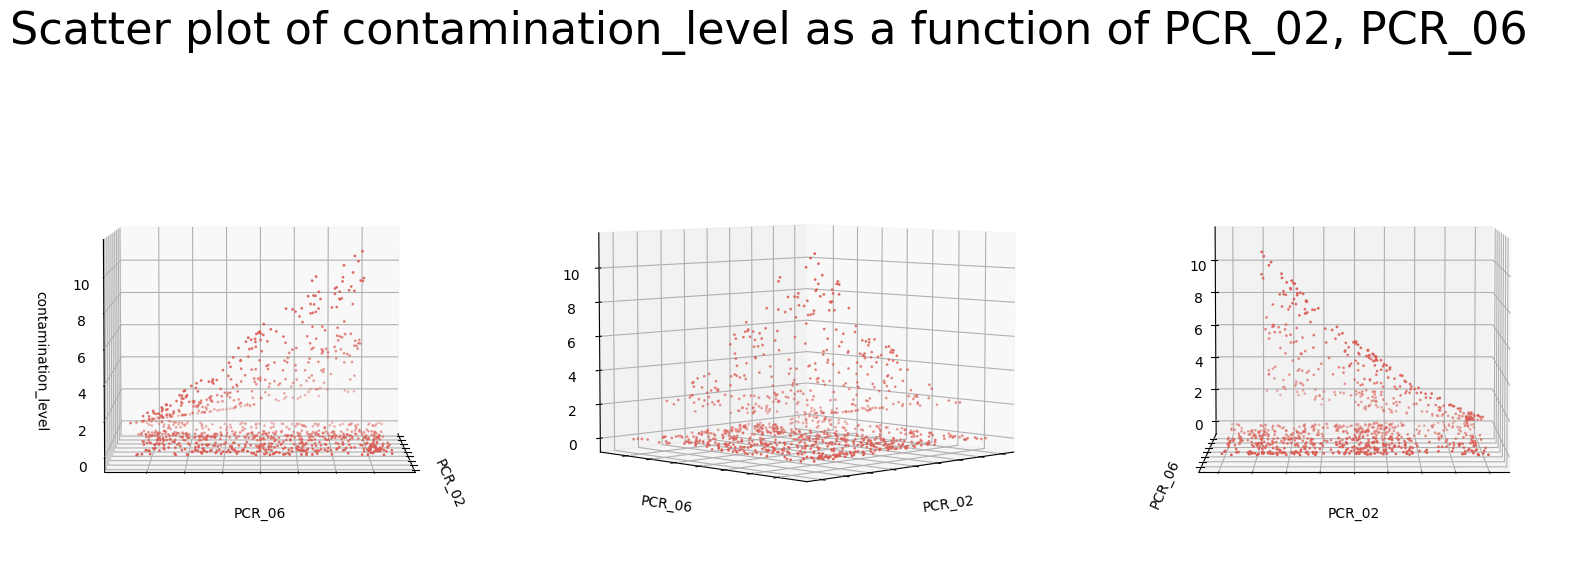

In [ ]:
# Section 4: Feature Mapping
#Q14
train_subset_features_spread = X_train_processed[['PCR_02', 'PCR_06']]
train_subset_target_spread = X_train_processed['contamination_level']
plot3d(X_train_processed, colX='PCR_02', colY='PCR_06', colZ='contamination_level', title="Scatter plot of contamination_level as a function of PCR_02, PCR_06 ")

<ipython-input-21-8d1e5cb89966>:25: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


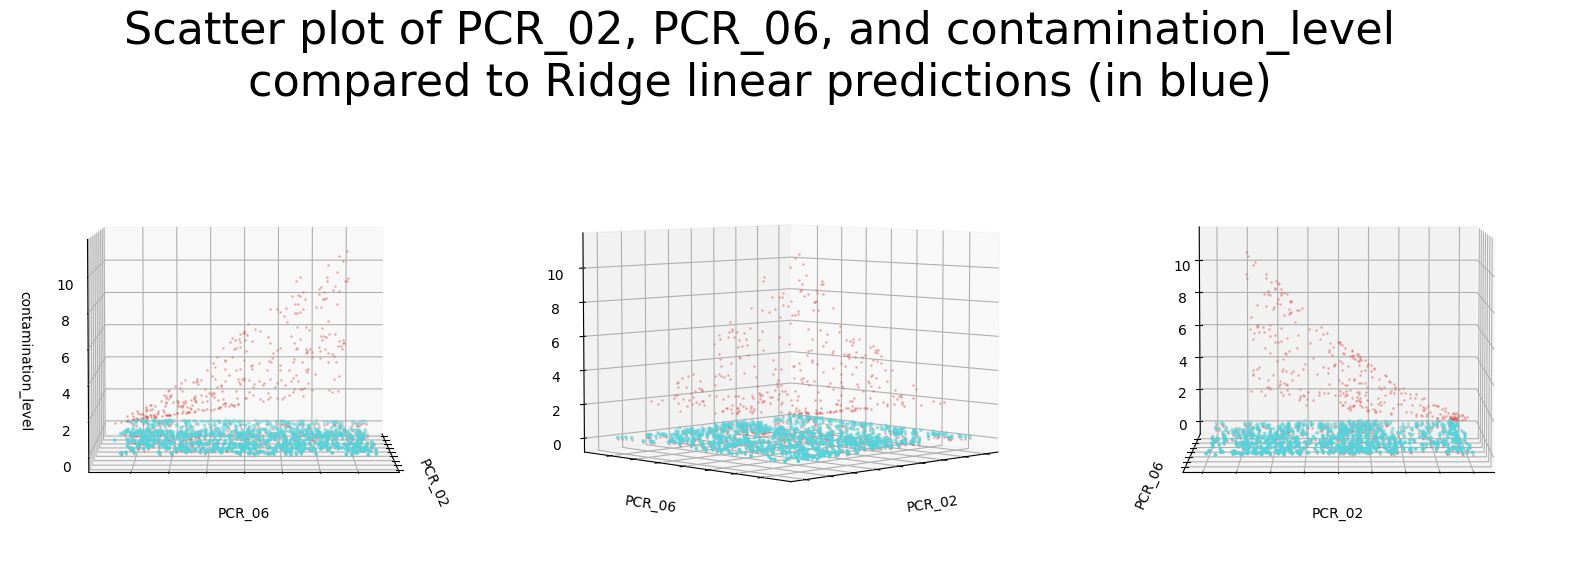

In [ ]:
#Q16
from sklearn.linear_model import HuberRegressor

huber = HuberRegressor(alpha=220, fit_intercept=True).fit(train_subset_features_spread, train_subset_target_spread)

plot3d(X_train_processed, colX='PCR_02', colY='PCR_06', colZ='contamination_level', title="Scatter plot of PCR_02, PCR_06, and contamination_level\ncompared to Ridge linear predictions (in blue)",
       predictions=huber.predict(train_subset_features_spread))


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics.pairwise import laplacian_kernel
from sklearn.model_selection import cross_validate

poly_reg = Pipeline([('normalization', MinMaxScaler()),('regressor', SVR(kernel=laplacian_kernel, tol=1e-5, C=1, epsilon=1))])


new_df_train = pd.DataFrame.copy(X_train_init[['PCR_02','PCR_06','contamination_level']])

X_train_pcr_and_contamination_not_normalized = new_df_train[['PCR_02','PCR_06']]

y_train_pcr_and_contamination_not_normalized = new_df_train[['contamination_level']]

new_df_train_section = pd.DataFrame.copy(X_train_init)

X_train_not_normalized = new_df_train_section

y_train_not_normalized = X_train_not_normalized[['contamination_level']]

X_train_not_normalized.drop('contamination_level', axis=1, inplace=True)

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:294: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True).astype(np.float64, copy=False)
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:294: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True).astype(np.float64, copy=False)
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:294: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True).astype(np.float64, copy=False)
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:294: DataConversionWarning: A column-vector y was passed when a 1d array

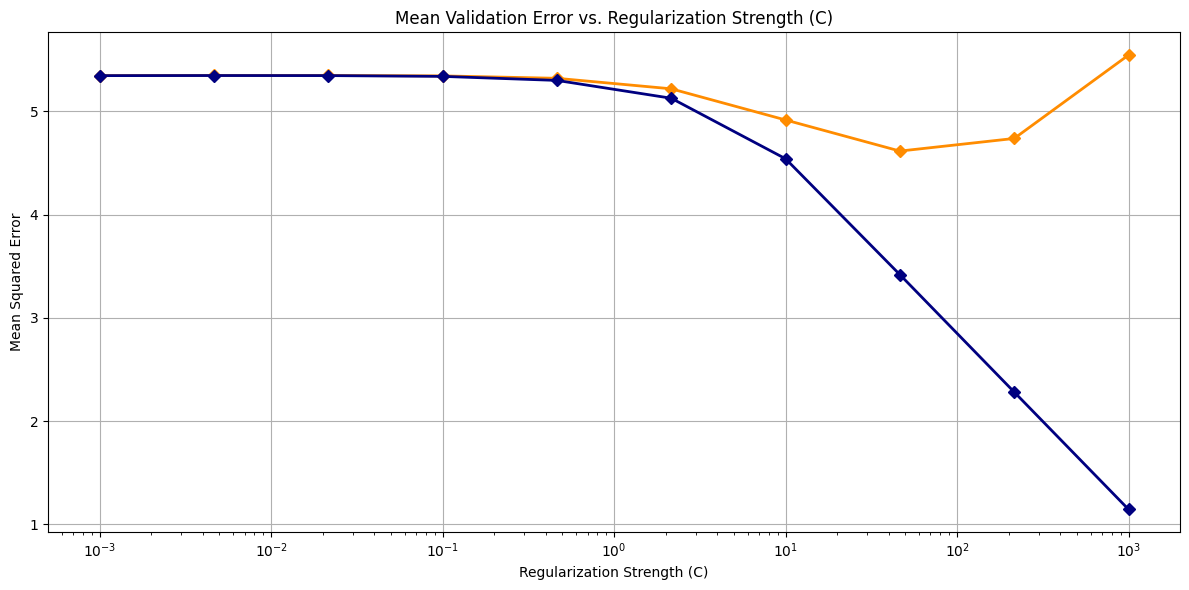

Optimal Strength (C) with Cross-Validation: 46.41588833612773
Mean Validation Error with Optimal Strength: 4.614948649306056
Mean train Error with Optimal Strength: 3.418576068099983


In [ ]:
#Q17

C_values = np.logspace(-3, 3, 10)

mean_train_errors = []
mean_val_errors = []

for c in C_values:
    poly_reg.set_params(regressor__C=c)

    cv_results = cross_validate(poly_reg, X_train_pcr_and_contamination_not_normalized, y_train_pcr_and_contamination_not_normalized, cv=5, scoring='neg_mean_squared_error' , return_train_score=True)

    mean_val_error = np.mean(-cv_results['test_score'])
    mean_train_error = np.mean(-cv_results['train_score'])

    mean_val_errors.append(mean_val_error)
    mean_train_errors.append(mean_train_error)


optimal_C = C_values[np.argmin(mean_val_errors)]

plt.figure(figsize=(12, 6))
plt.semilogx(C_values, mean_val_errors, label="Validation Score", color="darkorange", lw=2, marker='D')
plt.semilogx(C_values, mean_train_errors, label="Training Score", color="navy", lw=2, marker='D')
plt.title('Mean Validation Error vs. Regularization Strength (C)')
plt.xlabel('Regularization Strength (C)')
plt.ylabel('Mean Squared Error')
plt.xscale('log')
plt.grid(True)
plt.tight_layout()
plt.show()

print("Optimal Strength (C) with Cross-Validation:", optimal_C)
print("Mean Validation Error with Optimal Strength:", mean_val_errors[np.argmin(mean_val_errors)])
print("Mean train Error with Optimal Strength:", mean_train_errors[np.argmin(mean_val_errors)])

In [ ]:
poly_reg_new = Pipeline([('normalization', MinMaxScaler()),('regressor', SVR(kernel=laplacian_kernel, tol=1e-5, C=optimal_C, epsilon=1))])

poly_reg_new.fit(X_train_pcr_and_contamination_not_normalized, y_train_pcr_and_contamination_not_normalized)


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:294: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True).astype(np.float64, copy=False)


Pipeline(steps=[('normalization', MinMaxScaler()),
                ('regressor',
                 SVR(C=46.41588833612773, epsilon=1,
                     kernel=<function laplacian_kernel at 0x7d9407d7bf40>,
                     tol=1e-05))])

<ipython-input-21-8d1e5cb89966>:25: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


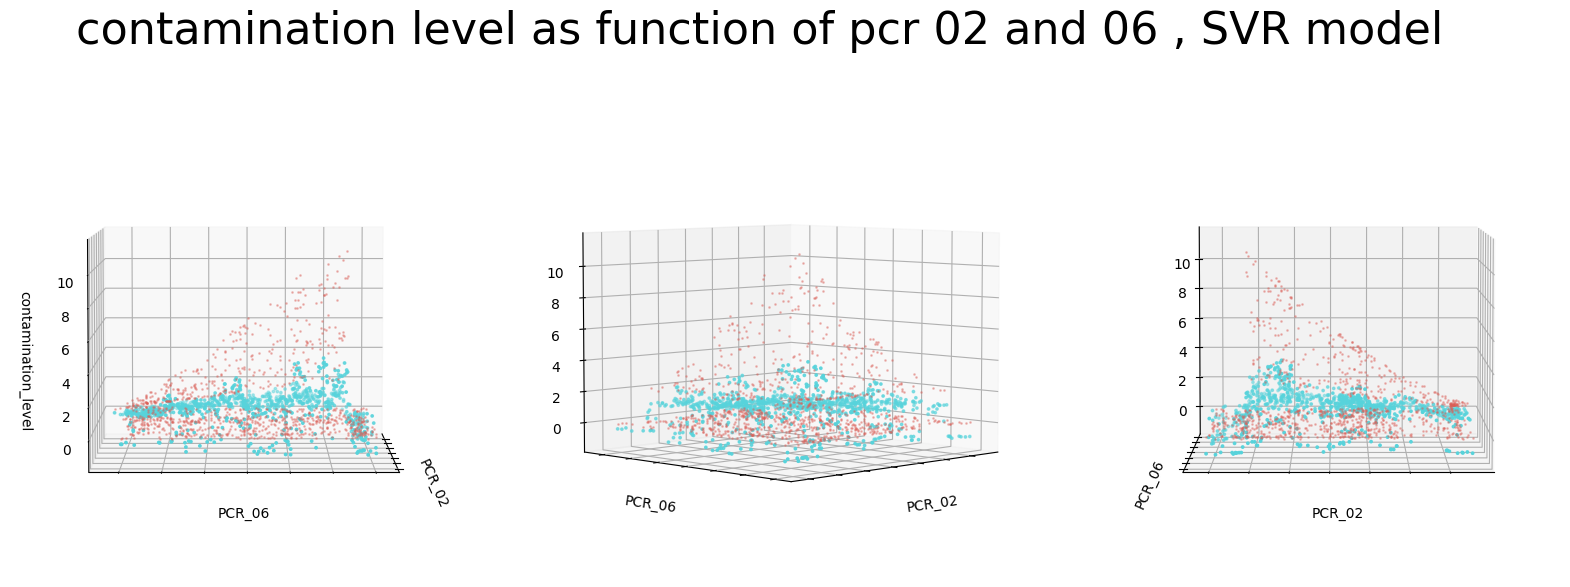

In [ ]:
predictions_poly_loss = poly_reg_new.predict(X_train_pcr_and_contamination_not_normalized)

plot3d(new_df_train,'PCR_02','PCR_06','contamination_level','contamination level as function of pcr 02 and 06 , SVR model',predictions_poly_loss)

In [ ]:
from sklearn.metrics import mean_squared_error

X_test = pd.DataFrame.copy(X_test_init)

y_test = X_test['contamination_level']

X_test.drop('contamination_level', axis=1, inplace=True)

In [ ]:
y_pred = dummy_regr.predict(X_test)

mse_dummy = mean_squared_error(y_test, y_pred)

print("Mean Squared Error of the linearRegressor:", mse_dummy)

Mean Squared Error of the linearRegressor: 5.1703733309222715


In [ ]:
Y_train_processed = X_train_processed['contamination_level']

In [ ]:
Q6_reg = LinearRegressor(lr=optimal_lr_value, delta=huber_delta)
x_con =[int(value) for value in X_train_processed['contamination_level']]

Q6_reg.fit(X_train_processed,x_con)


y_pred = Q6_reg.predict(X_test_processed)

mse_regressor = mean_squared_error(y_test, y_pred)
print("Mean Squared Error of the linearRegressor:", mse_regressor)

Mean Squared Error of the linearRegressor: 0.08365396626897294


In [ ]:
poly_reg_section_6 = Pipeline([('regressor', SVR(kernel=laplacian_kernel, tol=1e-5, C=optimal_C, epsilon=1))])

poly_reg_section_6.fit(X_train_processed,Y_train_processed)
y_pred = poly_reg_section_6.predict(X_test_processed)

mse_svr = mean_squared_error(y_test, y_pred)
print("Mean Squared Error of the svr laplace:", mse_svr)


Mean Squared Error of the svr laplace: 0.6200580131178223
